# ResNet-20 Model From Scratch

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def get_dataloaders(batch_size=128):
    
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2023, 0.1994, 0.2010))

    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2023, 0.1994, 0.2010))

    ])
    
    train_dataset = CIFAR10(
        root="./data", train=True, download=True, transform=train_transform,
    )

    test_dataset = CIFAR10(
        root="./data", train=False, download=True, transform=test_transform,
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )

    return train_loader, test_loader

In [4]:
def get_training_protocol(model, lr=0.1, momentum=0.9, weight_decay=0.0001):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        threshold=0.0001
    )

    return criterion, optimizer, scheduler

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.basic_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample = downsample
    
    def _initial_forward(self, x):
        x = self.basic_block(x)
        return x
    
    def forward(self, x):
        identity = x

        out = self._initial_forward(x)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity

        out = F.relu(out)

        return out

In [6]:
class ResNet20(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()

        self.initial_conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        num_blocks_per_layer = 3

        self.basic_block_1 = self._make_basic_block(16, 16, num_blocks_per_layer, stride=1)
        self.basic_block_2 = self._make_basic_block(16, 32, num_blocks_per_layer, stride=2)
        self.basic_block_3 = self._make_basic_block(32, 64, num_blocks_per_layer, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc_layer = nn.Linear(64, num_classes)

    def _make_basic_block(self, in_channels, out_channels, num_blocks_per_layer, stride=1):

        downsample = None

        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample=downsample))

        for _ in range(1, num_blocks_per_layer):
            layers.append(BasicBlock(out_channels, out_channels, stride=1, downsample=None))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.initial_conv_block(x)

        x = self.basic_block_1(x)
        x = self.basic_block_2(x)
        x = self.basic_block_3(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc_layer(x)

        return x


In [7]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()

    correct = 0.0
    total = 0.0

    loss_per_epoch = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    loss_per_epoch /= len(train_loader)
    accuracy = correct / total
    return loss_per_epoch, accuracy

In [8]:
def validate(model, test_loader, criterion, device):
    model.eval()

    correct = 0.0
    total = 0.0

    loss_per_epoch = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss_per_epoch += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    loss_per_epoch /= len(test_loader)

    return loss_per_epoch, accuracy

In [9]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy curves
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
resnet_20_model = ResNet20(num_classes=10).to(device)
resnet_20_model._initialize_weights()

train_loader, val_loader = get_dataloaders()
criterion, optimizer, scheduler = get_training_protocol(resnet_20_model)

EPOCHS = 50

In [15]:
train_history = {"train_loss":[], "train_acc":[]}
val_history = {"val_loss":[], "val_acc":[]}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(resnet_20_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(resnet_20_model, val_loader, criterion, device)

    scheduler.step(val_loss)

    train_history["train_loss"].append(train_loss)
    train_history["train_acc"].append(train_acc)
    
    val_history["val_loss"].append(val_loss)
    val_history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nTraining Complete")


Epoch 1/50 - Train Loss: 1.6544, Train Acc: 0.3772, Val Loss: 1.3819, Val Acc: 0.4894
Epoch 2/50 - Train Loss: 1.1089, Train Acc: 0.5985, Val Loss: 1.6279, Val Acc: 0.5254
Epoch 3/50 - Train Loss: 0.8923, Train Acc: 0.6841, Val Loss: 1.0370, Val Acc: 0.6578
Epoch 4/50 - Train Loss: 0.7637, Train Acc: 0.7306, Val Loss: 0.7636, Val Acc: 0.7453
Epoch 5/50 - Train Loss: 0.6799, Train Acc: 0.7637, Val Loss: 0.9345, Val Acc: 0.6951
Epoch 6/50 - Train Loss: 0.6107, Train Acc: 0.7876, Val Loss: 0.8964, Val Acc: 0.6976
Epoch 7/50 - Train Loss: 0.5654, Train Acc: 0.8042, Val Loss: 0.8116, Val Acc: 0.7369
Epoch 8/50 - Train Loss: 0.5366, Train Acc: 0.8135, Val Loss: 0.6841, Val Acc: 0.7745
Epoch 9/50 - Train Loss: 0.5022, Train Acc: 0.8268, Val Loss: 0.5740, Val Acc: 0.8072
Epoch 10/50 - Train Loss: 0.4765, Train Acc: 0.8368, Val Loss: 0.5694, Val Acc: 0.8050
Epoch 11/50 - Train Loss: 0.4587, Train Acc: 0.8422, Val Loss: 0.5767, Val Acc: 0.8115
Epoch 12/50 - Train Loss: 0.4477, Train Acc: 0.8449,

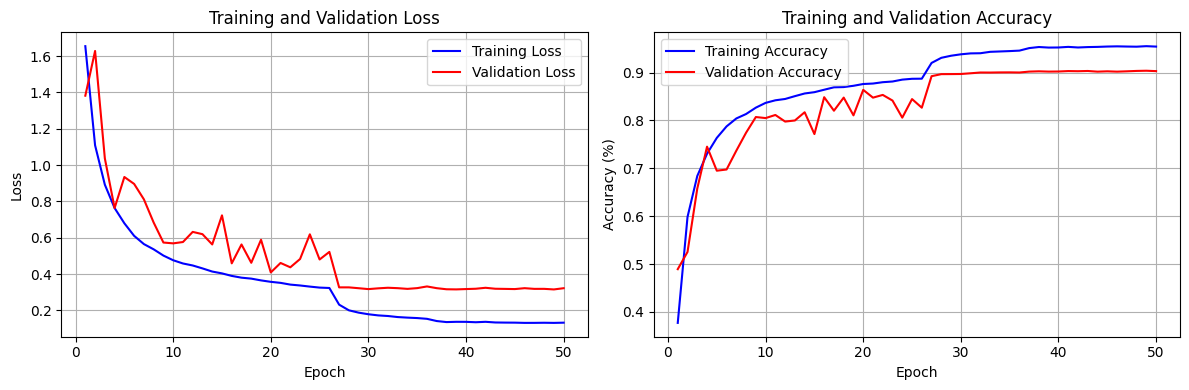

In [16]:
plot_learning_curves(train_history["train_loss"], val_history["val_loss"], train_history["train_acc"], val_history["val_acc"])